##### Authors: 
Michael Poli & Stefano Massaroli

In [1]:
%matplotlib inline

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from pyPH.numpy_simple import *

from scipy.integrate import odeint
from sklearn.model_selection import train_test_split

# Linear Boundary via Port-Hamiltonian Training

The following is a proof-of-concept for Port-Hamiltonian Neural Networks. The relatively simple task at hand is finding a linear boundary between data sampled from a multivariate gaussian distribution. A fully-connected network is then trained as Port-Hamiltonian Neural Network (PHNN) in continuous time.

# Generate blob data
Two classes: $\mathcal{C}_1$ and  $\mathcal{C}_2$

In [3]:
# Standard deviations of class distributions
sigma_C1 = 0.1
sigma_C2 = 0.1

# Means of the class distributions
mu_C1 = 0.6
mu_C2 = 0.25

# Number of samples of each class
N_C1 = 1000
N_C2 = 1000

In [4]:
np.random.seed(1)
C1 = np.random.multivariate_normal([0.6,0.7], [[0.025,0.0],[0.0,0.01]], N_C1)
np.random.seed(2)
C2 = np.random.multivariate_normal([0.1,0.2], [[0.025,-0.00],[-0.00,0.01]], N_C2)

X = np.vstack((C1,C2))

# Dataset generation (blobs)

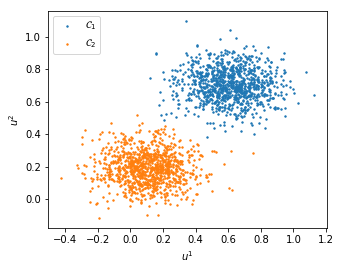

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(C1[:,0],C1[:,1],label='$\mathcal{C}_1$', rasterized=False, s=2);
plt.scatter(C2[:,0],C2[:,1],label='$\mathcal{C}_2$', rasterized=False, s=2);
plt.xlabel("$u^1$")
plt.ylabel("$u^2$")
plt.legend();

### Labels

In [6]:
y1 = np.hstack((np.ones((N_C1,1)),np.zeros((N_C1,1))))
y2 = np.hstack((np.zeros((N_C2,1)),np.ones((N_C2,1))))

y = np.vstack((y1,y2))

### Train/Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

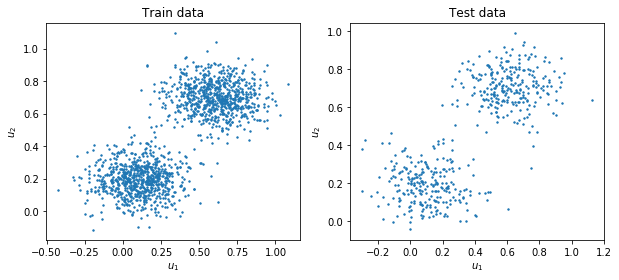

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X_train[:,0],X_train[:,1], rasterized=False, s=2)
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
plt.title('Train data')
plt.subplot(122)
plt.scatter(X_test[:,0],X_test[:,1], rasterized=False, s=2)
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
plt.title('Test data');

# Port-Hamiltonian NN (PHNN)

- Neural Network model: $y = f(u,\omega(t))$ 

- Regularized $\mathcal{L}_2$ Loss function: $\mathcal{J} = a\|\hat{y}-f(u,\omega(t))\|_2^2 + b\| \dot{\omega}\|_2^2+c\|{\omega}\|_2^2$ with $a,b,c\in\mathbb{R}^+$ (every minima of $\mathcal{J}$ is placed in $\dot{\omega} = 0$)

- "state" vector $x = \begin{bmatrix}\omega&\dot{\omega}\end{bmatrix}^\top$

- Gradient of $\mathcal{J}$: $\partial_x\mathcal{J} = \begin{bmatrix}\partial_\omega\mathcal{J}&\partial_\dot{\omega}\mathcal{J}\end{bmatrix}$ (row vector)

- Weights dynamics: 
\begin{align}
\begin{bmatrix}\dot{\omega}\\\ddot{\omega}\end{bmatrix} & = \begin{bmatrix}0&I_n\\-I_n&-B\end{bmatrix}\begin{bmatrix}\partial_\omega\mathcal{J}\\\partial_\dot{\omega}\mathcal{J}\end{bmatrix}\\
\Leftrightarrow  \dot{x} & = \begin{bmatrix}0&I_n\\-I_n&-B\end{bmatrix}(\partial_x\mathcal{J})^\top
\end{align}
where $B=B^\top>0$

### Simple model

Neural network model: $\begin{bmatrix}y_1\\y_2\end{bmatrix} =\begin{bmatrix}w_{11}u_1 + w_{12}u_2 + w_{13}\\w_{21}u_1 + w_{22}u_2 + w_{23}\end{bmatrix}$

### Training of a single $(\hat{u},\hat{y})$ tuple

In [9]:
# Initialize parameters for numerical integration
n = 6
# integration time
t = np.linspace(0, 10, 100)

# input
u = [0.6, 0.6]
# output
yh = [1., 0.]
# regularization term. diagonal value of B as defined above
beta = 0.5

# hyperparameters defining relative importance of squared-error, momentum and weight terms in the J*
a, b, c = 1., 1., 0.

# initial state: first n values represent weights, last n values momenta for corresponding weights
x0 = [0.6, -2.3, 0.1, -1.1, -1.2, 0.3, -1.2, 0.3, 0.2, 1.6, -0.4, 1.6]

In [10]:
x0

[0.6, -2.3, 0.1, -1.1, -1.2, 0.3, -1.2, 0.3, 0.2, 1.6, -0.4, 1.6]

In [11]:
sol = odeint(hamiltonian_model, x0, t, args=(u, yh, beta, a, b, c))

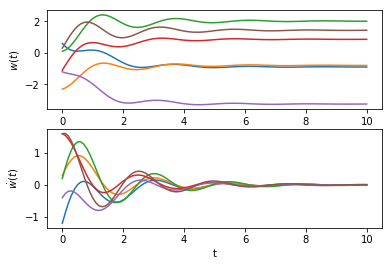

In [12]:
# Plot Weights
plt.figure()
plt.subplot(211)
plt.plot(t,sol[:,:n]);
plt.xlabel("$t$")
plt.ylabel("$w(t)$")
plt.subplot(212)
plt.plot(t,sol[:,n:2*n]);
plt.xlabel("t")
plt.ylabel("$\dot{w}(t)$");

In [13]:
# computing output
N = len(sol)
y = np.zeros((N,2))
J = np.zeros((N,1))
for i in range(N):
    y[i,:] = simple_net(u,sol[i])
    J[i] = loss(sol[i], u, yh, a, b, c)

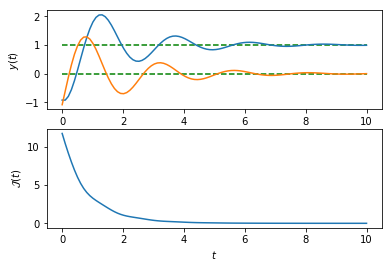

In [14]:
# Plot output 
yh1 = yh[0]*np.ones((N,1))
yh2 = yh[1]*np.ones((N,1))

plt.figure()
plt.subplot(211)
plt.plot(t, yh1, color='green', linestyle='dashed')
plt.plot(t, yh2, color='green', linestyle='dashed')
plt.plot(t, y)
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.subplot(212)
plt.plot(t,J)
plt.xlabel("$t$")
plt.ylabel("$\mathcal{J}(t)$");

#### Evaluate the effect of the hyperparameter: $c$

In [15]:
t = np.linspace(0, 5, 3000)
u = [0.6,0.6]
yh = [1.,0.]
beta = 3
a = 1.
b = 1.
n = 6
x0 = [0.6,-2.3,-0.1,-1.1,-1.2,0.3,-1.2,0.3,0.2,1.6,-0.4,1.6]

N = 100 # number of trials
# between 0 and 1
c_it = np.linspace(0, 1, N)
err = np.zeros((N, 1))
norm = np.zeros((N, 1))
for i in range(N):
    c = c_it[i]
    sol = odeint(hamiltonian_model, x0, t, args=(u, yh, beta, a, b, c))
    temp = sol[-1]
    # loss
    err[i] = loss(sol[-1],u, yh,1.,1., 0.)
    #norm of weights
    norm[i] = np.linalg.norm(temp[0:n])

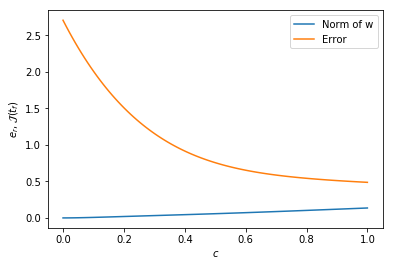

In [16]:
plt.figure()
plt.plot(c_it, err)
plt.plot(c_it, norm)
plt.legend(['Norm of w', 'Error'])
plt.xlabel("$c$")
plt.ylabel("$e_r$, $\mathcal{J}(t_f)$");

# Training on the entire dataset

In [17]:
n_samples = 2000
X_tr = np.array(X_train[:n_samples], dtype='float')
y_tr = np.array(y_train[:n_samples], dtype='float')

### Method #1: Sequential "Update & Converge" training
NOTE: This procedure integrates for time `t` for each ($u,\hat{y}$) and might thus take some time.

- initialize: weights, first IN and OUT ($u,\hat{y}$) of the dataset 
- Integrate for a while (until convergence)
- Feed a new IN-OUT
- Integrate again
- repeat

In [19]:
bs = 1
epochs = 100
# random init of weights and momenta (6 - 6)
x0 = [0.6, -2.3, -0.1, -1.1, -1.2, 0.3, -1.2, 0.3, 0.1, 1.6, -0.4, 1.6]

a = 1.
b = 1.
c = 0.001

beta = 100.
n = 6
t = np.linspace(0, 0.1, 10)

#
tf, xf, J, xep, Jep = train(X_tr, y_tr, bs, epochs, x0, a, b, c, beta, t);

#### Weight trajectories & Loss

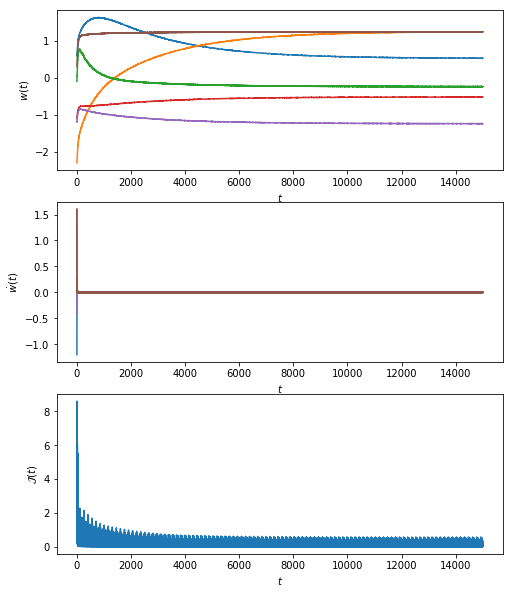

In [20]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(tf,xf[:,:n]);
plt.xlabel("$t$")
plt.ylabel("$w(t)$")
plt.subplot(312)
plt.plot(tf,xf[:,n:2*n]);
plt.xlabel("$t$")
plt.ylabel("$\dot{w}(t)$")
plt.subplot(313)
plt.plot(tf,J);
plt.xlabel("$t$")
plt.ylabel("$\mathcal{J}(t)$");

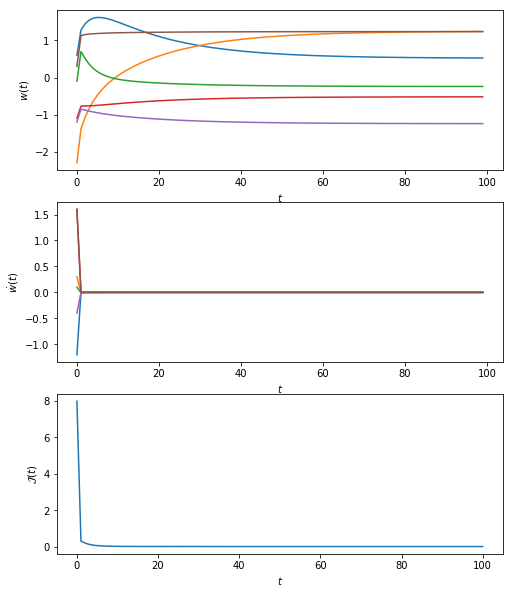

In [21]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(xep[:,:n]);
plt.xlabel("$t$")
plt.ylabel("$w(t)$")
plt.subplot(312)
plt.plot(xep[:,n:2*n]);
plt.xlabel("$t$")
plt.ylabel("$\dot{w}(t)$")
plt.subplot(313)
plt.plot(Jep);
plt.xlabel("$t$")
plt.ylabel("$\mathcal{J}(t)$");

#### Decision Boundary Plot

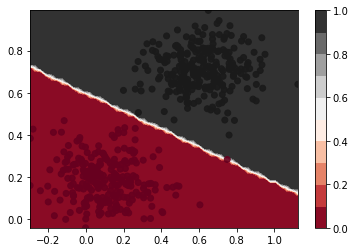

In [29]:
x_range = [X_test.min(0)[0], X_test.max(0)[0]]
y_range = [X_test.min(0)[1], X_test.max(0)[1]]
num_p = 50
u1 = np.linspace(x_range[0], x_range[1], num_p)
u2 = np.linspace(y_range[0], y_range[1], num_p)
U1, U2 = np.meshgrid(u1, u2)
Y = np.zeros((num_p, num_p))

for i in range(num_p):
    for j in range(num_p):
        u = [U1[i,j], U2[i,j]]
        y_ij = simple_net(u, xf[-1])
        if y_ij[0] > y_ij[1]:
            Y[i,j] = 1
        if (y_ij[0] >= 0.499) and (y_ij[0]<=0.509):
            Y[i,j] = y_ij[0]
plt.figure()
plt.contourf(U1, U2, Y, 10,cmap='RdGy')
plt.colorbar();
plt.scatter(X_test[:,0], X_test[:,1], c=y_test[:,0],cmap='RdGy',alpha = 0.9)
plt.xlim(x_range)
plt.ylim(y_range);

## Method #2: Batch Training 

We train on a batch of arbitrary size

Example: whole dataset

Given
\begin{equation}
u = [u_1,u_2,\dots,u_i,\dots,u_N]\quad \hat{y} = [\hat{y}_1,\hat{y}_2,\dots,\hat{y}_i,\dots,\hat{y}_N]
\end{equation}
Rename $\mathcal{J}$: 
\begin{equation}
\mathcal{J} = \frac{1}{N}\sum_{i=1}^N\mathcal{J}_i(u_i,y_i,\omega(t))
\end{equation}
where
\begin{equation}
\mathcal{J}_i(u_i,y_i,\omega(t)) =  a\|\hat{y}_i-f(u_i,\omega(t))\|_2^2 + b\|\dot{\omega}\|_2^2 + c\|{\omega}\|_2^2
\end{equation}

### Train on the whole dataset 

In [30]:
# Initialise parameters for numerical integration
t = np.linspace(0, 60, 600)
#x0 = np.array(np.random.randn(2*n))
# fixed randomization
x0 = [0.63248614,-2.28817298,-0.09513922,-1.08199499,-1.23973685,0.3197053,
      -1.21213162,0.29433111,0.07164353,1.57434972,-0.36218658,1.60029132]

U = X_tr 
Yh = y_tr
beta = 0.1
a = 1.
b = 1.
c = 0.01
n = 6
bs = 1000

In [32]:
sol = odeint(ham_mod_batch, x0, t, args=(bs, U, Yh, beta, a, b, c))

### Weight trajectories

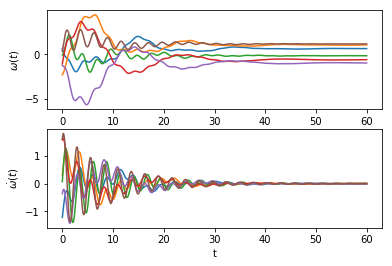

In [35]:
plt.figure()
plt.subplot(211)
plt.plot(t,sol[:, :n]);
plt.xlabel("t")
plt.ylabel("$\omega(t)$")
plt.subplot(212)
plt.plot(t,sol[:, n:2*n]);
plt.xlabel("t")
plt.ylabel("$\dot{\omega}(t)$");

#### Loss

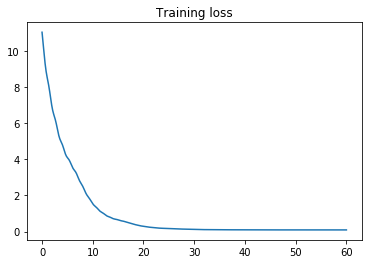

In [37]:
N = len(sol)
J = np.zeros((N,1))
for i in range(N):
    J[i] = loss_batch(bs, sol[i], U, Yh, a, b, c)
plt.figure()
plt.plot(t,J)
plt.title("Training loss");